In [1]:
import os
import glob
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

from llava.constants import IMAGE_TOKEN_INDEX
from llava.model.builder import load_pretrained_model
from llava.mm_utils import get_model_name_from_path, tokenizer_image_token

/home/chengzhang/anaconda3/envs/minigpt4/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2023-11-03 03:32:22,373] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [2]:
model_base = None  # "/home/chengzhang/models/llava/llava-v1-0719-336px-lora-merge-vicuna-13b-v1.3"
model_path = "/home/chengzhang/models/llava/llava-v1.5-7b"  # "/home/chengzhang/models/llava/llava-336px-pretrain-vicuna-13b-v1.3"
model_name = get_model_name_from_path(model_path)
tokenizer, model, image_processor, context_len = load_pretrained_model(
    model_path, model_base, model_name
)

Loading checkpoint shards: 100%|██████████| 2/2 [00:03<00:00,  1.67s/it]


In [3]:
linear_modules: dict[str, torch.nn.Linear] = {}

for i, layer in enumerate(model.model.layers):
    linear_modules[f'llama/{i}-q-proj'] = layer.self_attn.q_proj
    # linear_modules[f'llama/{i}-k-proj'] = layer.self_attn.k_proj
    # linear_modules[f'llama/{i}-v-proj'] = layer.self_attn.v_proj
    linear_modules[f'llama/{i}-o-proj'] = layer.self_attn.o_proj
    # linear_modules[f'llama/{i}-gate-proj'] = layer.mlp.gate_proj
    linear_modules[f'llama/{i}-down-proj'] = layer.mlp.down_proj
    linear_modules[f'llama/{i}-up-proj'] = layer.mlp.up_proj

for name, module in linear_modules.items():
    module.unique_name = name

ln_modules: dict[str, torch.nn.Linear] = {}

for i, layer in enumerate(model.model.layers):
    ln_modules[f'llama/{i}-input-ln'] = layer.input_layernorm
    ln_modules[f'llama/{i}-post-attn-ln'] = layer.post_attention_layernorm

for name, module in ln_modules.items():
    module.unique_name = name

In [2]:
with open('/home/chengzhang/datasets/OK-VQA/question/OpenEnded_mscoco_val2014_questions.json') as f:
    questions = json.loads(f.read())['questions']

hooks = []

In [3]:
SNAPSHOT_PATH = '/home/chengzhang/Multimodal-Quantization/LLaVA/snapshot'

In [6]:
def save_activations(hooks):

    for i in range(100):

        q = questions[i]
        question = q['question']
        question_id = q['question_id']
        text = f'Question: {question} answer:'

        input_ids = torch.tensor(tokenizer(text)['input_ids']).unsqueeze(0).cuda()

        # act_folder = f'{SNAPSHOT_PATH}/activations-text/{question_id}'
        act_folder = f'{SNAPSHOT_PATH}/activations-text-gen-long/{question_id}'
        os.makedirs(f'{act_folder}/vit', exist_ok=True)
        os.makedirs(f'{act_folder}/q-former', exist_ok=True)
        os.makedirs(f'{act_folder}/llama', exist_ok=True)

        for hook in hooks:
            hook.remove()
        hooks = []

        cache = {}

        def hook(m, input, output):
            # torch.save(input, f'{act_folder}/{m.unique_name}.pt')
            # print(f'[{m.unique_name}] {len(input)} {input[0].shape}')
            if input[0].shape[1] == 1:
                if m.unique_name in cache:
                    cache[m.unique_name] = torch.concat((cache[m.unique_name], input[0]), 1)
                else:
                    cache[m.unique_name] = input[0]

        for name, module in linear_modules.items():
            hooks.append(module.register_forward_hook(hook))

        for name, module in ln_modules.items():
            hooks.append(module.register_forward_hook(hook))

        # model(input_ids=input_ids)

        model.generate(
            input_ids,
            do_sample=False,
            max_new_tokens=50,
            use_cache=True,
        )

        print(f'\n ########## [{i}] {question_id} ({len(cache)}) ##########')

        for name, val in cache.items():
            # print(name, val.shape)
            torch.save((val, ), f'{act_folder}/{name}.pt')

# save_activations(hooks)


 ########## [0] 2971475 (192) ##########

 ########## [1] 3397615 (192) ##########

 ########## [2] 3575865 (192) ##########

 ########## [3] 949225 (192) ##########

 ########## [4] 2076115 (192) ##########

 ########## [5] 5723996 (192) ##########

 ########## [6] 5759705 (192) ##########

 ########## [7] 3045575 (192) ##########

 ########## [8] 2183655 (192) ##########

 ########## [9] 2863135 (192) ##########

 ########## [10] 299845 (192) ##########

 ########## [11] 115115 (192) ##########

 ########## [12] 3234605 (192) ##########

 ########## [13] 5169165 (192) ##########

 ########## [14] 217115 (192) ##########

 ########## [15] 3133865 (192) ##########

 ########## [16] 4026395 (192) ##########

 ########## [17] 4575845 (192) ##########

 ########## [18] 4883775 (192) ##########

 ########## [19] 3017535 (192) ##########

 ########## [20] 1833195 (192) ##########

 ########## [21] 3970635 (192) ##########

 ########## [22] 4976605 (192) ##########

 ########## [23] 2357845

In [2]:
def load_act(
    path: str,
    comp: str,
    seq_start: int = 0,
    seq_end: int = 10,
    token_start: int = None,
    token_end: int = None
) -> np.ndarray:
    acts = []
    tokens = 0
    for i in range(seq_start, seq_end):
        question_id = questions[i]['question_id']
        act_folder = f'{path}/{question_id}'
        act: torch.Tensor = torch.load(f'{act_folder}/llama/{comp}.pt')[0][0]
        if token_end is not None:
            act = act[:token_end]
        if token_start is not None:
            act = act[token_start:]
        if act.shape[0] > 0:
            acts.append(act.abs().max(dim=0).values.detach())
        # acts.append(act.abs().sum(dim=0).detach())
        tokens += act.shape[0]
    return torch.stack(acts).max(dim=0).values.cpu().numpy()
    # return (torch.stack(acts).sum(dim=0) / tokens).cpu().numpy()

In [3]:
def plot_layer_2(left: np.ndarray, right: np.ndarray, titles: list[str], outliers_rate: float = 0.01):
    channels = left.shape[-1]
    outliers = round(channels * outliers_rate)

    left_outliers = left.argsort()[-outliers:]
    right_outliers = right.argsort()[-outliers:]
    left_spec_outliers = set(left_outliers) - set(right_outliers)
    right_spec_outliers = set(right_outliers) - set(left_outliers)
    print(len(left_spec_outliers))

    left_colors = np.tile(np.array([0x1f, 0x77, 0xb4]) / 255, (channels, 1))
    right_colors = np.tile(np.array([0x1f, 0x77, 0xb4]) / 255, (channels, 1))
    for idx in left_outliers:
        left_colors[idx] = np.array([0x2c, 0xa0, 0x2c]) / 255
    for idx in right_outliers:
        right_colors[idx] = np.array([0x2c, 0xa0, 0x2c]) / 255
    for idx in left_spec_outliers:
        left_colors[idx] = np.array([0xd6, 0x27, 0x28]) / 255
    for idx in right_spec_outliers:
        right_colors[idx] = np.array([0xd6, 0x27, 0x28]) / 255
    
    max_val = max(left.max(), right.max())

    print(left.argmax(), left.max())
    print(right.argmax(), right.max())

    groups = (channels + 512 - 1) // 512

    plt.figure(figsize=(15, 2 * groups))

    def plot_group(tensor, colors, start, stop, idx, title=None):
        ax = plt.subplot(groups, 2, idx)
        ax.bar(np.arange(start, stop), tensor[start:stop], width=np.ones(stop - start), color=colors[start:stop])
        # ax.set_ylim(0, np.ceil(max_val))
        ax.set_ylim(0, max_val)
        # ax.set_ylim(0, 0.2)
        ax.set_xlim(start, start + 512)
        ax.set_xticks(np.arange(start, start + 513, 64))
        if title is not None:
            ax.set_title(title)

    for group_id in range(groups):
        start = group_id * 512
        stop = min(start + 512, channels)
        plot_group(left, left_colors, start, stop, group_id * 2 + 1, titles[1] if group_id == 0 else None)
        plot_group(right, right_colors, start, stop, group_id * 2 + 2, titles[2] if group_id == 0 else None)

    plt.suptitle(titles[0])

In [4]:
def plot_layer_3(left: np.ndarray, mid: np.ndarray, right: np.ndarray, titles: list[str]):
    channels = left.shape[-1]
    outliers = channels // 100

    left_outliers = left.argsort()[-outliers:]
    mid_outliers = mid.argsort()[-outliers:]
    right_outliers = right.argsort()[-outliers:]
    common_outliers = set(left_outliers) & set(mid_outliers) & set(right_outliers)
    left_spec_outliers = set(left_outliers) - common_outliers
    mid_spec_outliers = set(mid_outliers) - common_outliers
    right_spec_outliers = set(right_outliers) - common_outliers
    print(len(mid_spec_outliers))

    left_colors = np.tile(np.array([0x1f, 0x77, 0xb4]) / 255, (channels, 1))
    mid_colors = np.tile(np.array([0x1f, 0x77, 0xb4]) / 255, (channels, 1))
    right_colors = np.tile(np.array([0x1f, 0x77, 0xb4]) / 255, (channels, 1))
    for idx in left_outliers:
        left_colors[idx] = np.array([0x2c, 0xa0, 0x2c]) / 255
    for idx in mid_outliers:
        mid_colors[idx] = np.array([0x2c, 0xa0, 0x2c]) / 255
    for idx in right_outliers:
        right_colors[idx] = np.array([0x2c, 0xa0, 0x2c]) / 255
    for idx in left_spec_outliers:
        left_colors[idx] = np.array([0xd6, 0x27, 0x28]) / 255
    for idx in mid_spec_outliers:
        mid_colors[idx] = np.array([0xd6, 0x27, 0x28]) / 255
    for idx in right_spec_outliers:
        right_colors[idx] = np.array([0xd6, 0x27, 0x28]) / 255
    
    max_val = max(left.max(), mid.max(), right.max())

    print(left.argmax(), left.max())
    print(mid.argmax(), mid.max())
    print(right.argmax(), right.max())

    groups = (channels + 512 - 1) // 512

    plt.figure(figsize=(22, 2 * groups))

    def plot_group(tensor, colors, start, stop, idx, title=None):
        ax = plt.subplot(groups, 3, idx)
        ax.bar(np.arange(start, stop), tensor[start:stop], width=np.ones(stop - start), color=colors[start:stop])
        # ax.set_ylim(0, max_val)
        ax.set_ylim(0, 0.2)
        # ax.set_xlim(start, start + 512)
        ax.set_xticks(np.arange(start, start + 513, 64))
        if title is not None:
            ax.set_title(title)

    for group_id in range(groups):
        start = group_id * 512
        stop = min(start + 512, channels)
        plot_group(left, left_colors, start, stop, group_id * 3 + 1, titles[1] if group_id == 0 else None)
        plot_group(mid, mid_colors, start, stop, group_id * 3 + 2, titles[2] if group_id == 0 else None)
        plot_group(right, right_colors, start, stop, group_id * 3 + 3, titles[3] if group_id == 0 else None)

    plt.suptitle(titles[0])

In [9]:
# layer = 0
# comp = 'down-proj'
# vision_per_channel = load_act(f'{SNAPSHOT_PATH}/activations', f'{layer}-{comp}', token_end=577)
# # text_per_channel = load_act(f'{SNAPSHOT_PATH}/activations', f'{layer}-{comp}', token_start=577)
# text_per_channel = load_act(f'{SNAPSHOT_PATH}/activations-text', f'{layer}-{comp}', seq_end=100)
# gen_per_channel = load_act(f'{SNAPSHOT_PATH}/activations-gen', f'{layer}-{comp}')
# titles = [
#     f'[Layer #{layer}] {comp} Activations',
#     'Vision',
#     'Text',
#     'Gen',
# ]
# plot_layer_3(vision_per_channel, text_per_channel, gen_per_channel, titles)

618
10472 1.567
2591 4.418


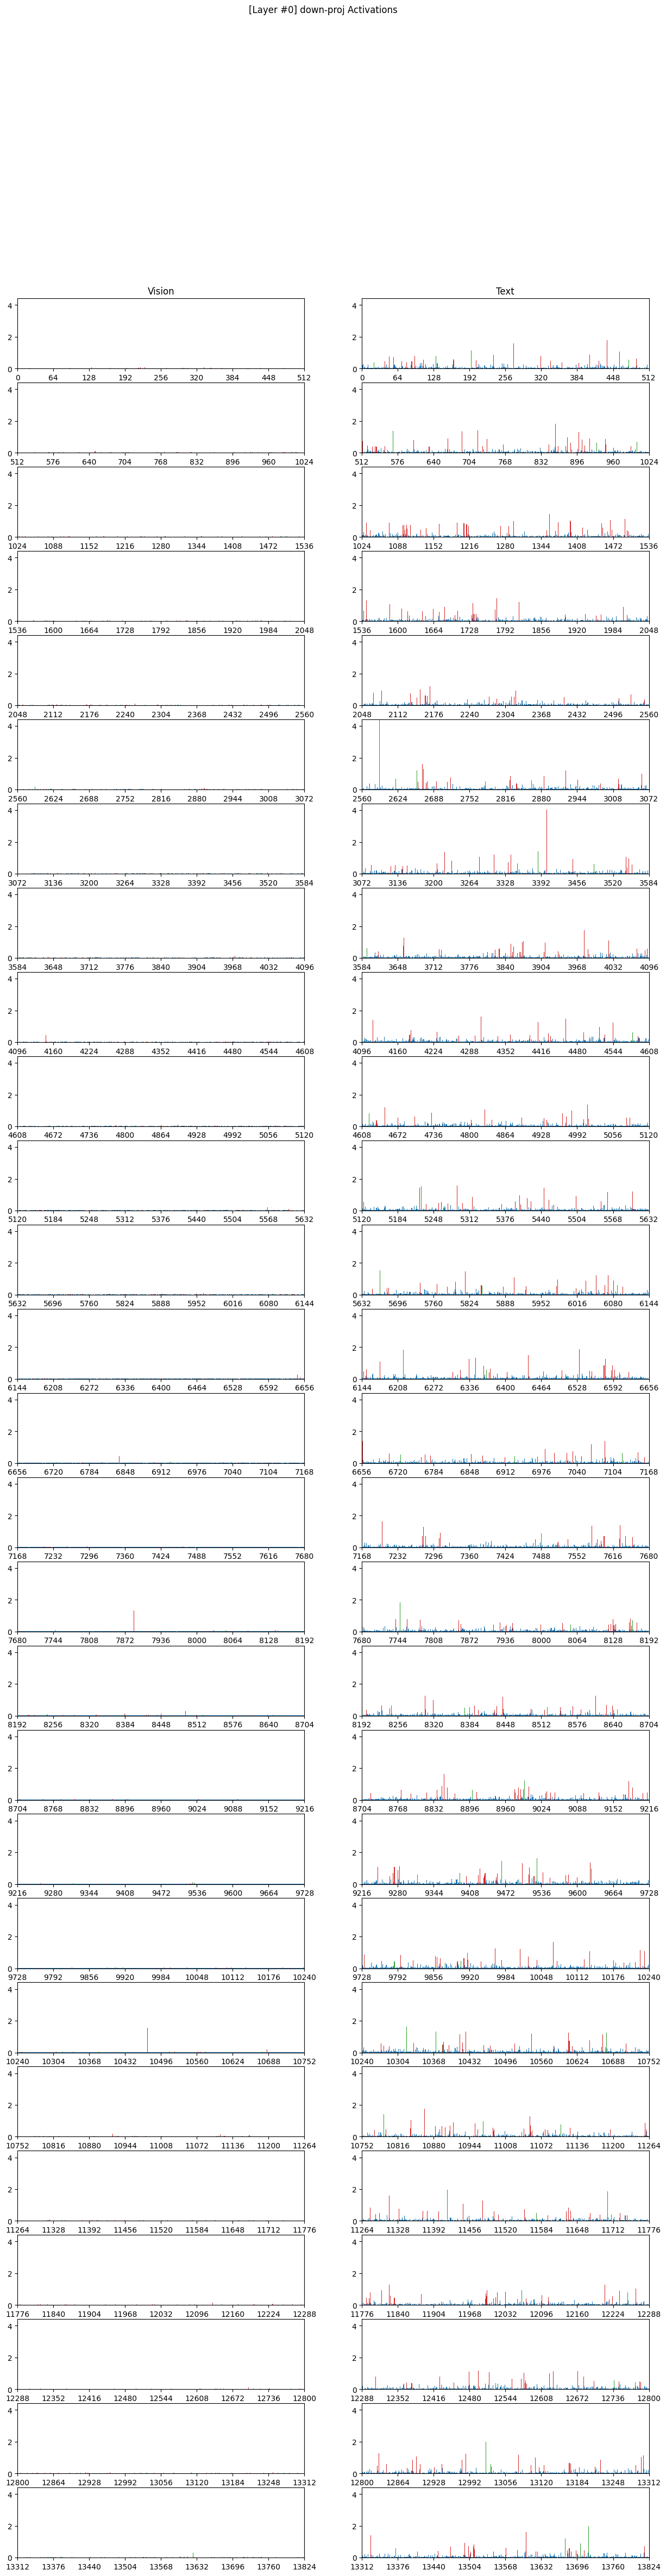

In [8]:
layer = 0
comp = 'down-proj'
vision_per_channel = load_act(f'{SNAPSHOT_PATH}/activations-13b', f'{layer}-{comp}', token_start=1, token_end=577)
text_per_channel = load_act(f'{SNAPSHOT_PATH}/activations-text-13b', f'{layer}-{comp}', seq_end=100)
titles = [
    f'[Layer #{layer}] {comp} Activations',
    'Vision',
    'Text',
]
plot_layer_2(vision_per_channel, text_per_channel, titles, outliers_rate=0.05)

37
4057 2.227
2231 6.652


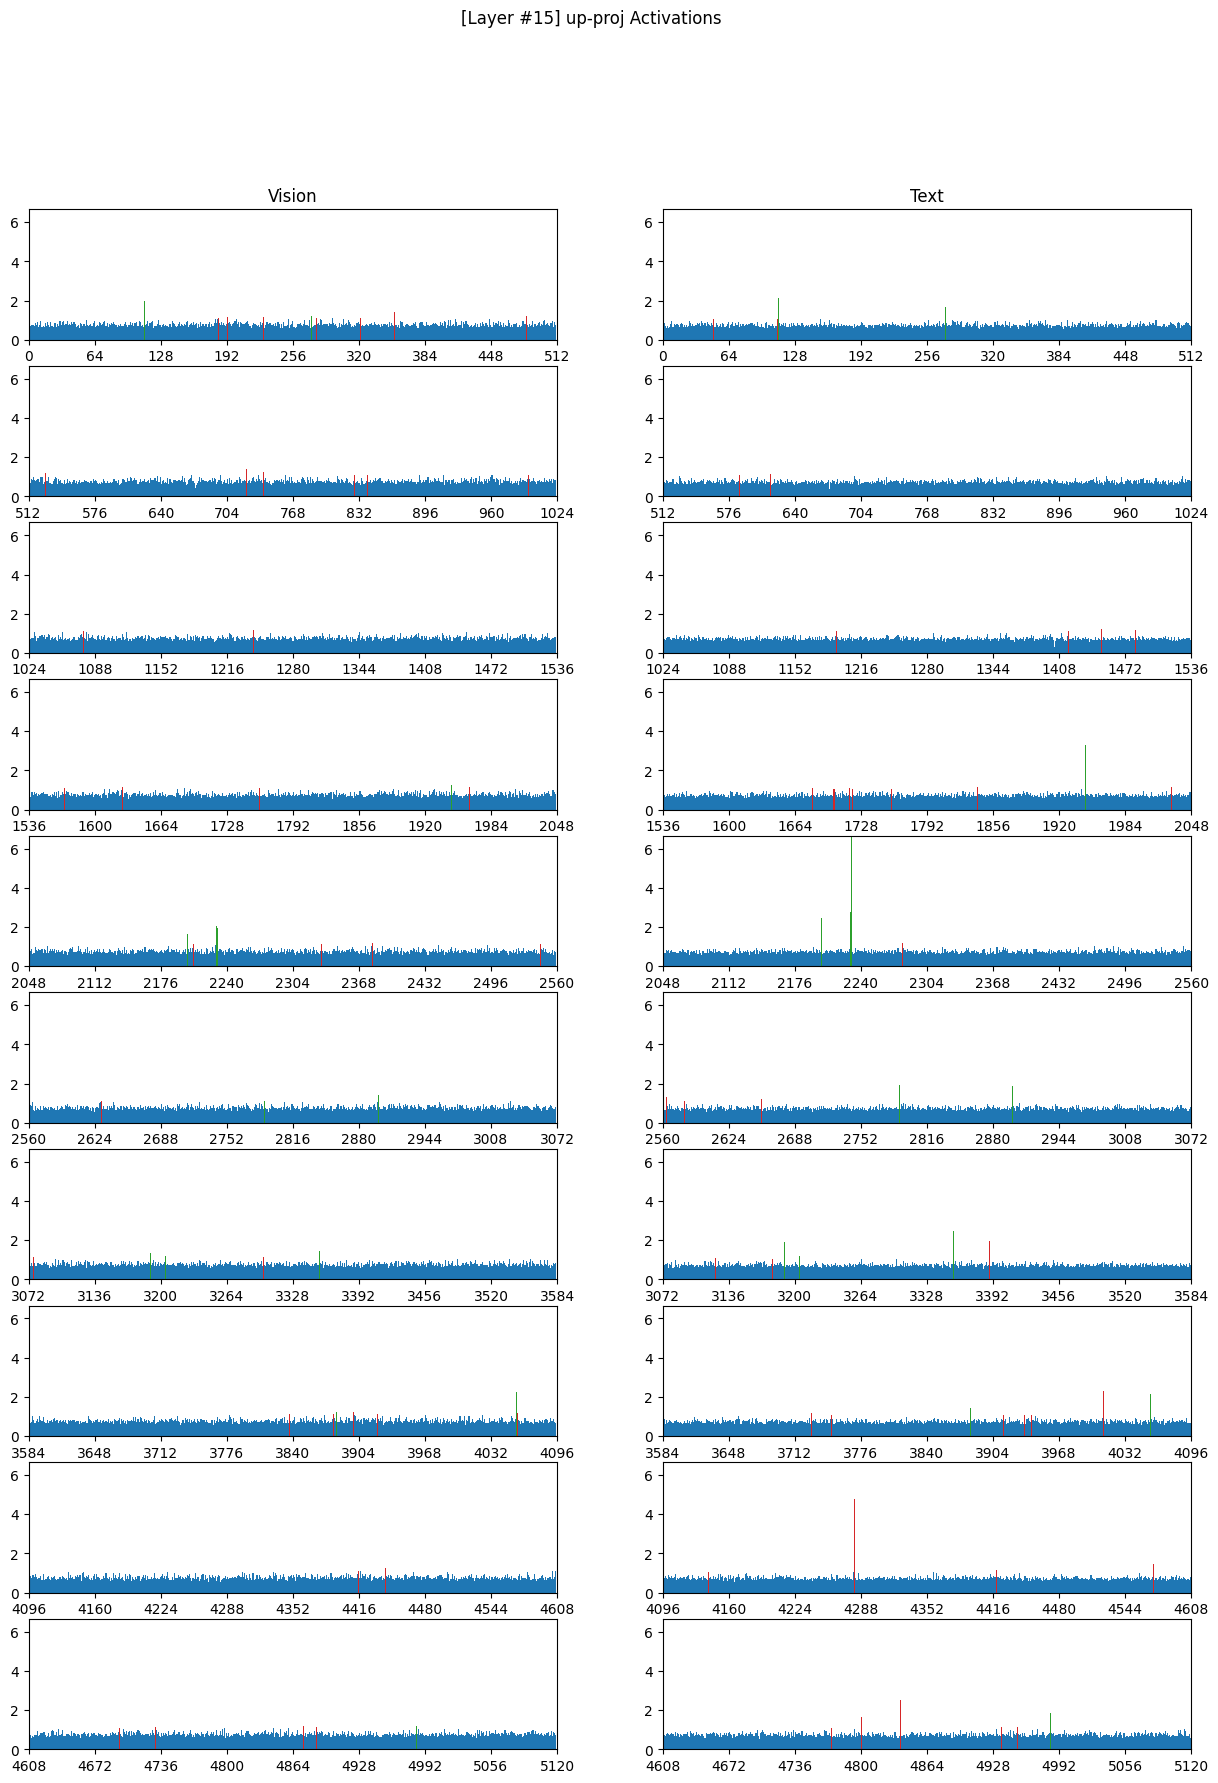

In [10]:
layer = 15
comp = 'up-proj'
vision_per_channel = load_act(f'{SNAPSHOT_PATH}/activations-13b', f'{layer}-{comp}', token_start=1, token_end=577)
text_per_channel = load_act(f'{SNAPSHOT_PATH}/activations-text-13b', f'{layer}-{comp}', seq_end=100)
titles = [
    f'[Layer #{layer}] {comp} Activations',
    'Vision',
    'Text',
]
plot_layer_2(vision_per_channel, text_per_channel, titles, outliers_rate=0.01)

In [4]:
def load_channel(
    path: str,
    comp: str,
    channel: int,
    seq_start: int = 0,
    seq_end: int = 10,
    token_start: int = None,
    token_end: int = None
) -> np.ndarray:
    acts = []
    tokens = 0
    for i in range(seq_start, seq_end):
        question_id = questions[i]['question_id']
        act_folder = f'{path}/{question_id}'
        act: torch.Tensor = torch.load(f'{act_folder}/llama/{comp}.pt')[0][0]
        act = act[:, channel]
        if token_end is not None:
            act = act[:token_end]
        if token_start is not None:
            act = act[token_start:]
        acts.append(act)
        tokens += act.shape[0]
    return torch.concat(acts)


bits = 4
bins = 2 ** (bits - 1)
ticks = np.square(np.arange(-1, 1, 1 / bins))
ticks[:bins] *= -1
ticks = ticks[1:]


def plot_channel(ax: plt.Axes, x: np.ndarray, plot_ticks: bool = False, bins: int = 200):
    scale = np.abs(x).max()
    thres = scale * 0.99
    quant_x = np.where(np.abs(x) < thres, x, 0.0)
    quant_scale = np.abs(quant_x).max()
    freqs, _, _ = ax.hist(x, bins=bins)
    if plot_ticks:
        for pos in ticks:
            ax.plot([pos * quant_scale, pos * quant_scale], [0, max(freqs)], color='C1', linewidth=1)

In [11]:
def plot_all_comp(layer, channel):
    plt.figure(figsize=(15, 16))

    for i, comp in enumerate(['q-proj', 'o-proj', 'up-proj', 'down-proj']):
        title = f'[L{layer}.{comp}] Text (Prompt)'
        ax = plt.subplot(4, 3, i * 3 + 1)
        x = load_channel(f'{SNAPSHOT_PATH}/activations-text', f'{layer}-{comp}', channel, seq_end=100).detach().cpu().numpy()
        plot_channel(ax, x)
        ax.set_title(title)
        print(title)
        # title = f'[L{layer}.{comp}] Multimodal (Text + Gen)'
        title = f'[L{layer}.{comp}] Text (Gen)'
        ax = plt.subplot(4, 3, i * 3 + 2)
        # x1 = load_channel(f'{SNAPSHOT_PATH}/activations', f'{layer}-{comp}', channel, token_start=577).detach().cpu().numpy()
        # x2 = load_channel(f'{SNAPSHOT_PATH}/activations-gen', f'{layer}-{comp}', channel, seq_end=100).detach().cpu().numpy()
        # x = np.concatenate([x1, x2])
        x = load_channel(f'{SNAPSHOT_PATH}/activations-text-gen-long', f'{layer}-{comp}', channel, seq_end=100).detach().cpu().numpy()
        plot_channel(ax, x)
        ax.set_title(title)
        print(title)
        # title = f'[L{layer}.{comp}] Multimodal (Vision)'
        title = f'[L{layer}.{comp}] Multimodal (Gen)'
        ax = plt.subplot(4, 3, i * 3 + 3)
        # x = load_channel(f'{SNAPSHOT_PATH}/activations', f'{layer}-{comp}', channel, token_start=1, token_end=577).detach().cpu().numpy()
        x = load_channel(f'{SNAPSHOT_PATH}/activations-gen-long', f'{layer}-{comp}', channel, seq_end=100).detach().cpu().numpy()
        plot_channel(ax, x)
        ax.set_title(title)
        print(title)

    plt.savefig(f'./snapshot/img/activations-per-channel/{layer}.{channel}.png')

[L3.q-proj] Text (Prompt)
[L3.q-proj] Text (Gen)
[L3.q-proj] Multimodal (Gen)
[L3.o-proj] Text (Prompt)
[L3.o-proj] Text (Gen)
[L3.o-proj] Multimodal (Gen)
[L3.up-proj] Text (Prompt)
[L3.up-proj] Text (Gen)
[L3.up-proj] Multimodal (Gen)
[L3.down-proj] Text (Prompt)
[L3.down-proj] Text (Gen)
[L3.down-proj] Multimodal (Gen)


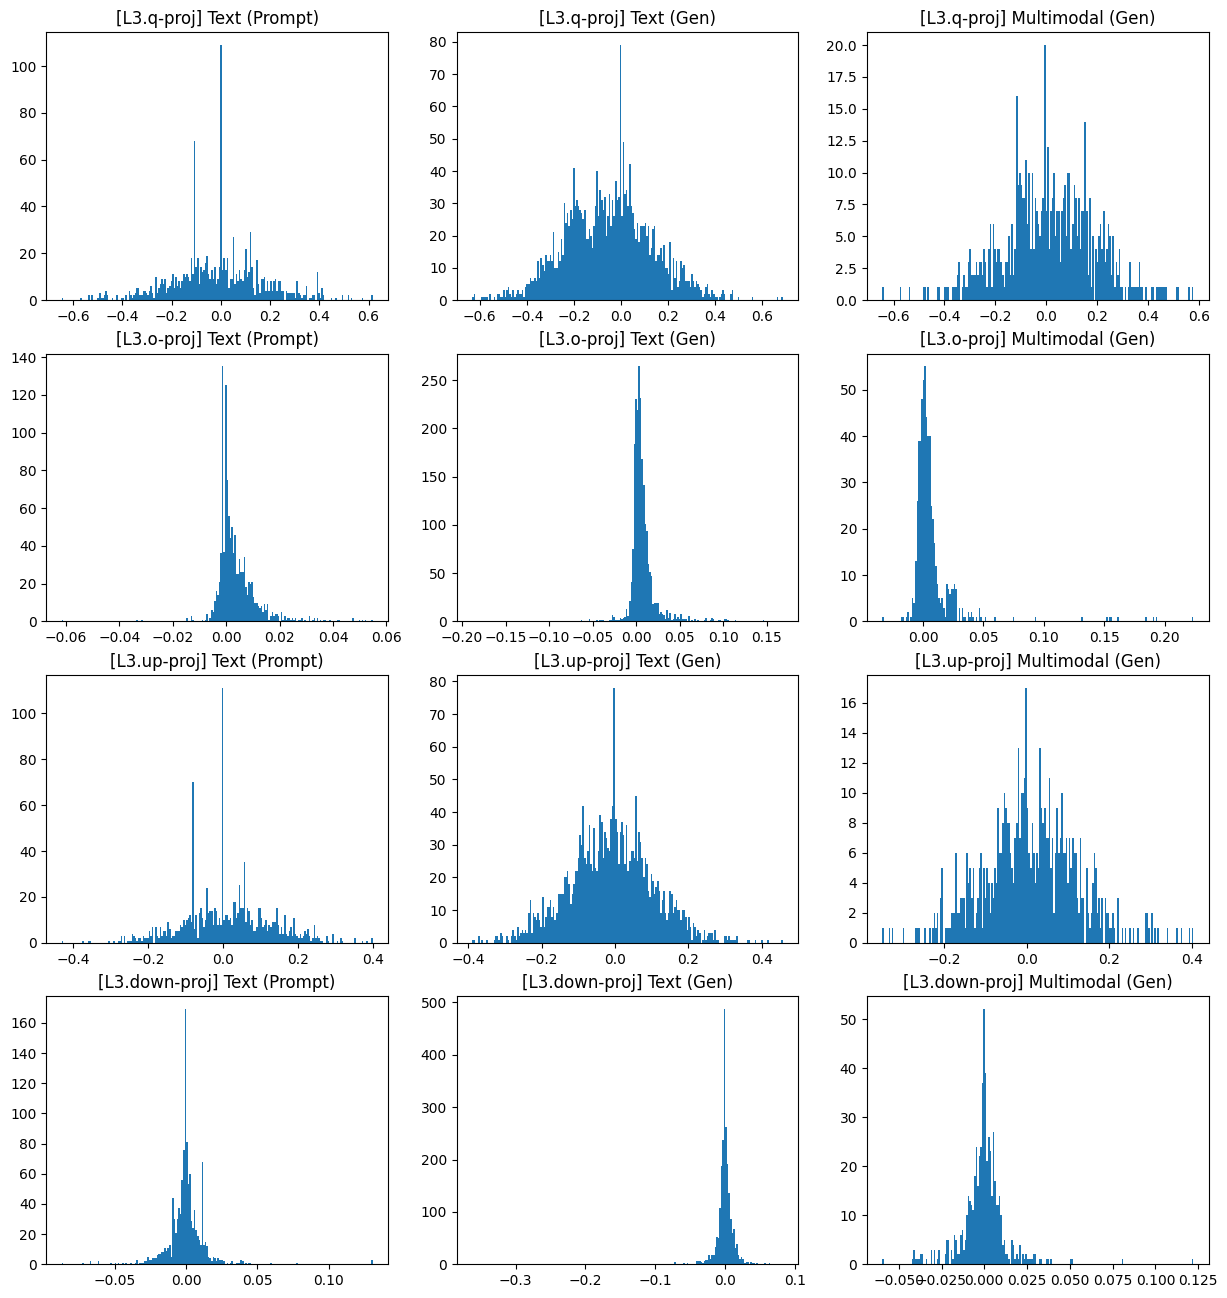

In [13]:
layer=3
plot_all_comp(layer, channel=31)

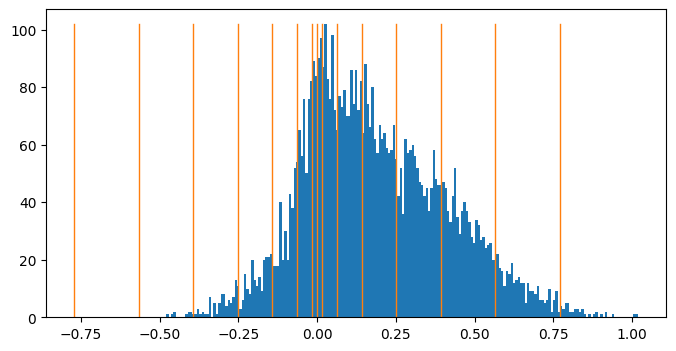

In [ ]:
layer = 15
comp = 'up-proj'
x = load_channel(f'{SNAPSHOT_PATH}/activations', f'{layer}-{comp}', 31, token_start=1, token_end=577).detach().cpu().numpy()
plot_channel(x)

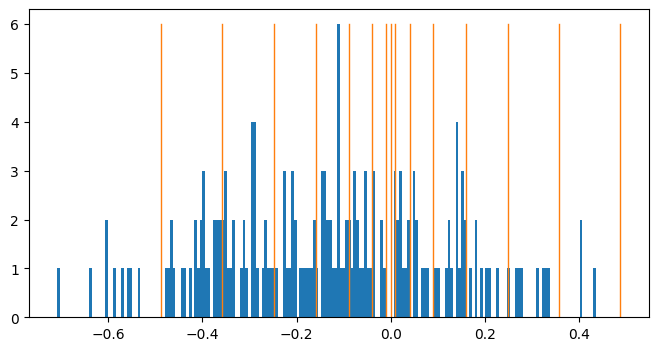

In [ ]:
layer = 15
comp = 'up-proj'
x = load_channel(f'{SNAPSHOT_PATH}/activations', f'{layer}-{comp}', 31, token_start=577).detach().cpu().numpy()
plot_channel(x)

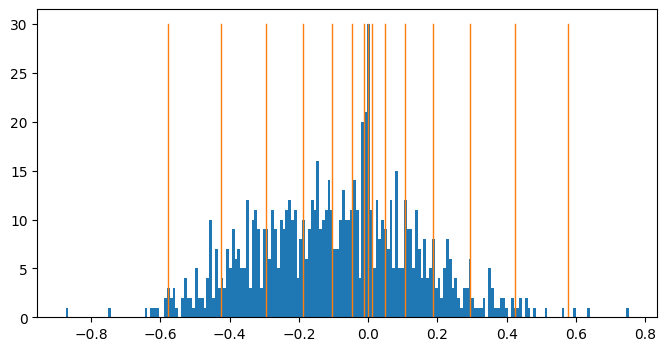

In [ ]:
layer = 15
comp = 'up-proj'
x = load_channel(f'{SNAPSHOT_PATH}/activations-gen', f'{layer}-{comp}', 31, seq_end=100).detach().cpu().numpy()
plot_channel(x)

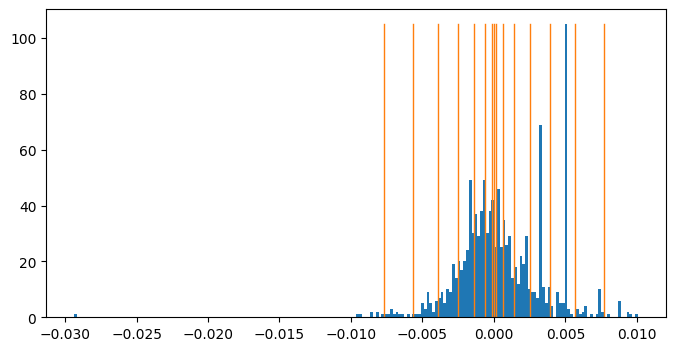

In [ ]:
layer = 0
comp = 'down-proj'
x = load_channel(f'{SNAPSHOT_PATH}/activations-text', f'{layer}-{comp}', 31, seq_end=100).detach().cpu().numpy()
plot_channel(x)

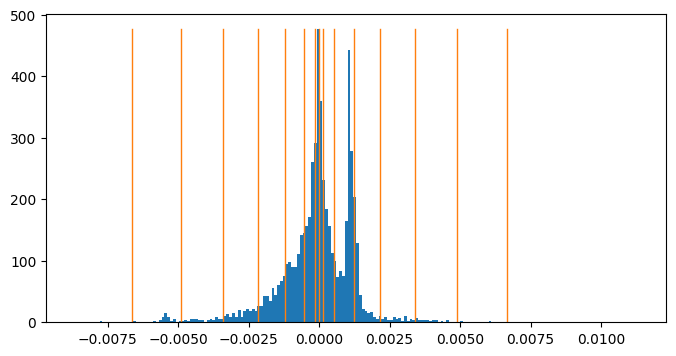

In [ ]:
layer = 0
comp = 'down-proj'
x = load_channel(f'{SNAPSHOT_PATH}/activations', f'{layer}-{comp}', 31, token_start=1, token_end=577).detach().cpu().numpy()
plot_channel(x)

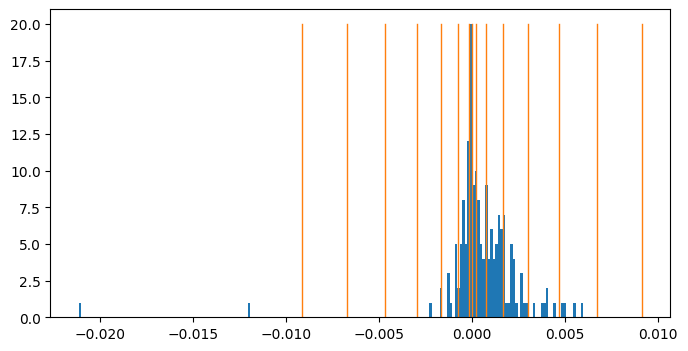

In [ ]:
layer = 0
comp = 'down-proj'
x = load_channel(f'{SNAPSHOT_PATH}/activations', f'{layer}-{comp}', 31, token_start=577).detach().cpu().numpy()
plot_channel(x)

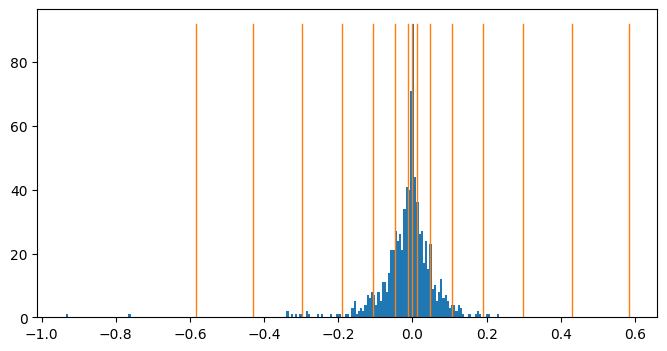

In [ ]:
layer = 15
comp = 'down-proj'
x = load_channel(f'{SNAPSHOT_PATH}/activations-gen', f'{layer}-{comp}', 31, seq_end=100).detach().cpu().numpy()
plot_channel(x)

4
310 8.9
310 8.555


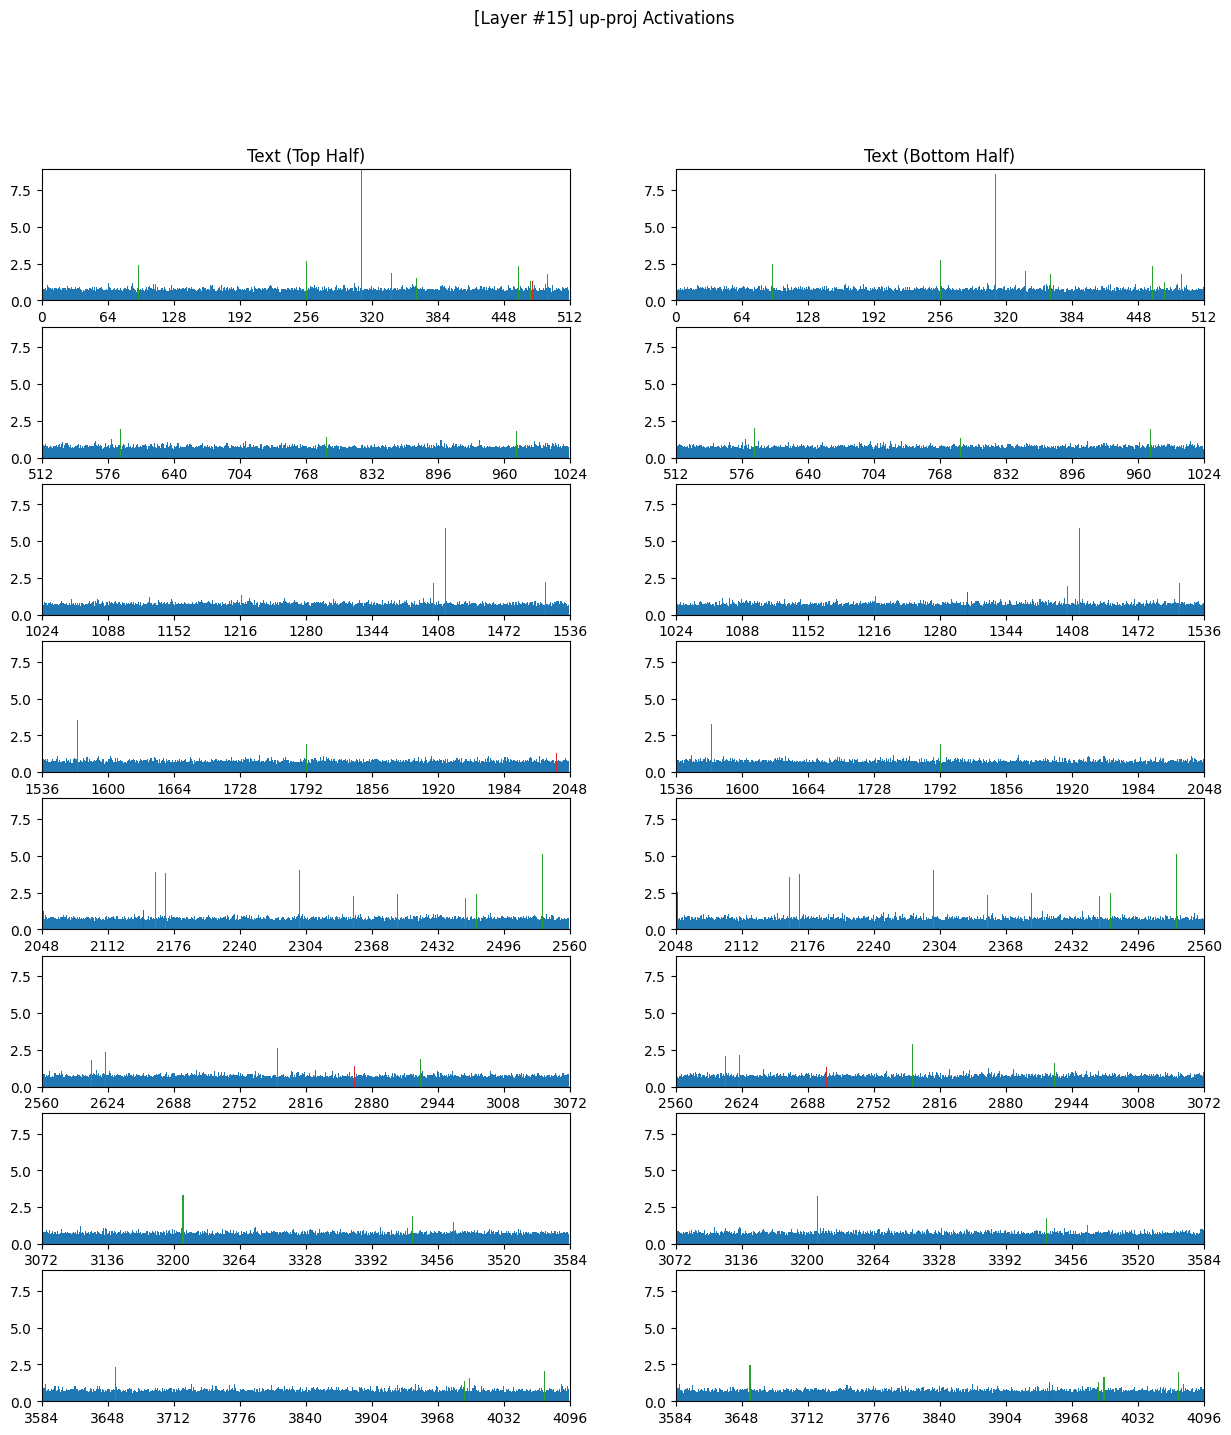

In [ ]:
layer = 15
comp = 'up-proj'
text_per_channel_1 = load_act(f'{SNAPSHOT_PATH}/activations-text', f'{layer}-{comp}', seq_start=0, seq_end=50)
text_per_channel_2 = load_act(f'{SNAPSHOT_PATH}/activations-text', f'{layer}-{comp}', seq_start=50, seq_end=100)
titles = [
    f'[Layer #{layer}] {comp} Activations',
    'Text (Top Half)',
    'Text (Bottom Half)',
]
plot_layer_2(text_per_channel_1, text_per_channel_2, titles)

3
1076 15.71
1076 15.58


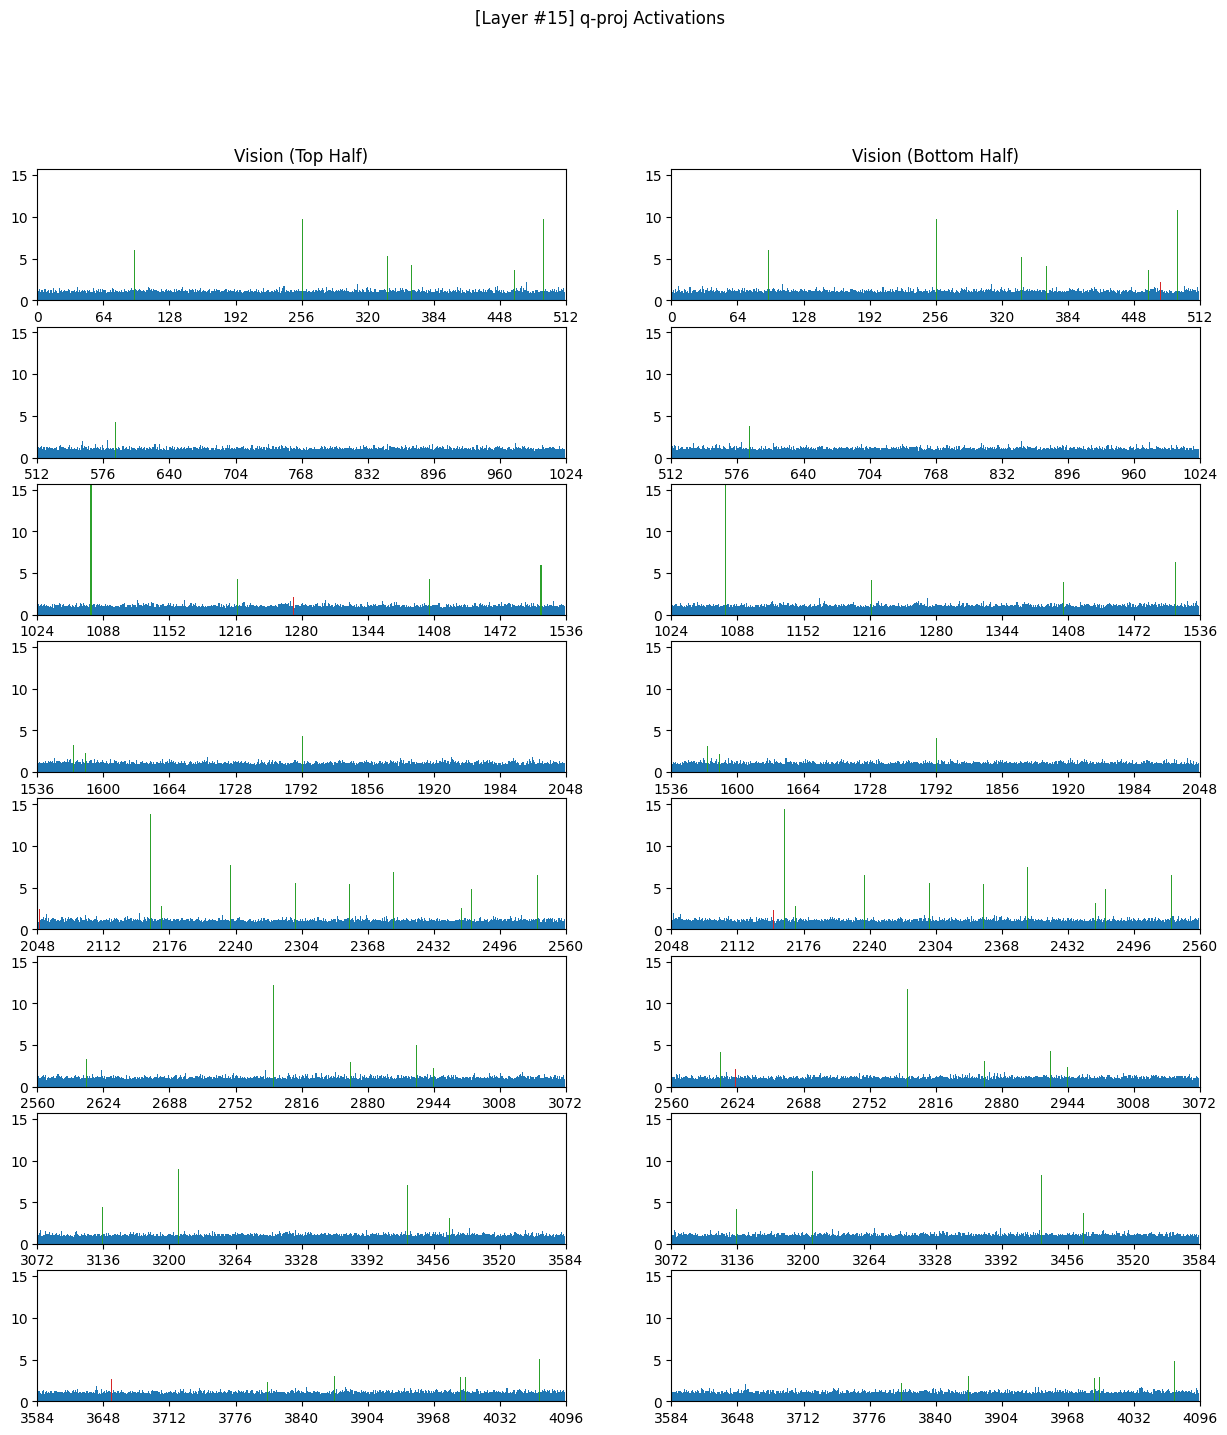

In [ ]:
layer = 15
comp = 'q-proj'
mm_per_channel_1 = load_act(f'{SNAPSHOT_PATH}/activations', f'{layer}-{comp}', seq_start=0, seq_end=5, token_end=577)
mm_per_channel_2 = load_act(f'{SNAPSHOT_PATH}/activations', f'{layer}-{comp}', seq_start=5, seq_end=10, token_end=577)
titles = [
    f'[Layer #{layer}] {comp} Activations',
    'Vision (Top Half)',
    'Vision (Bottom Half)',
]
plot_layer_2(mm_per_channel_1, mm_per_channel_2, titles)

2
310 9.49
310 9.47


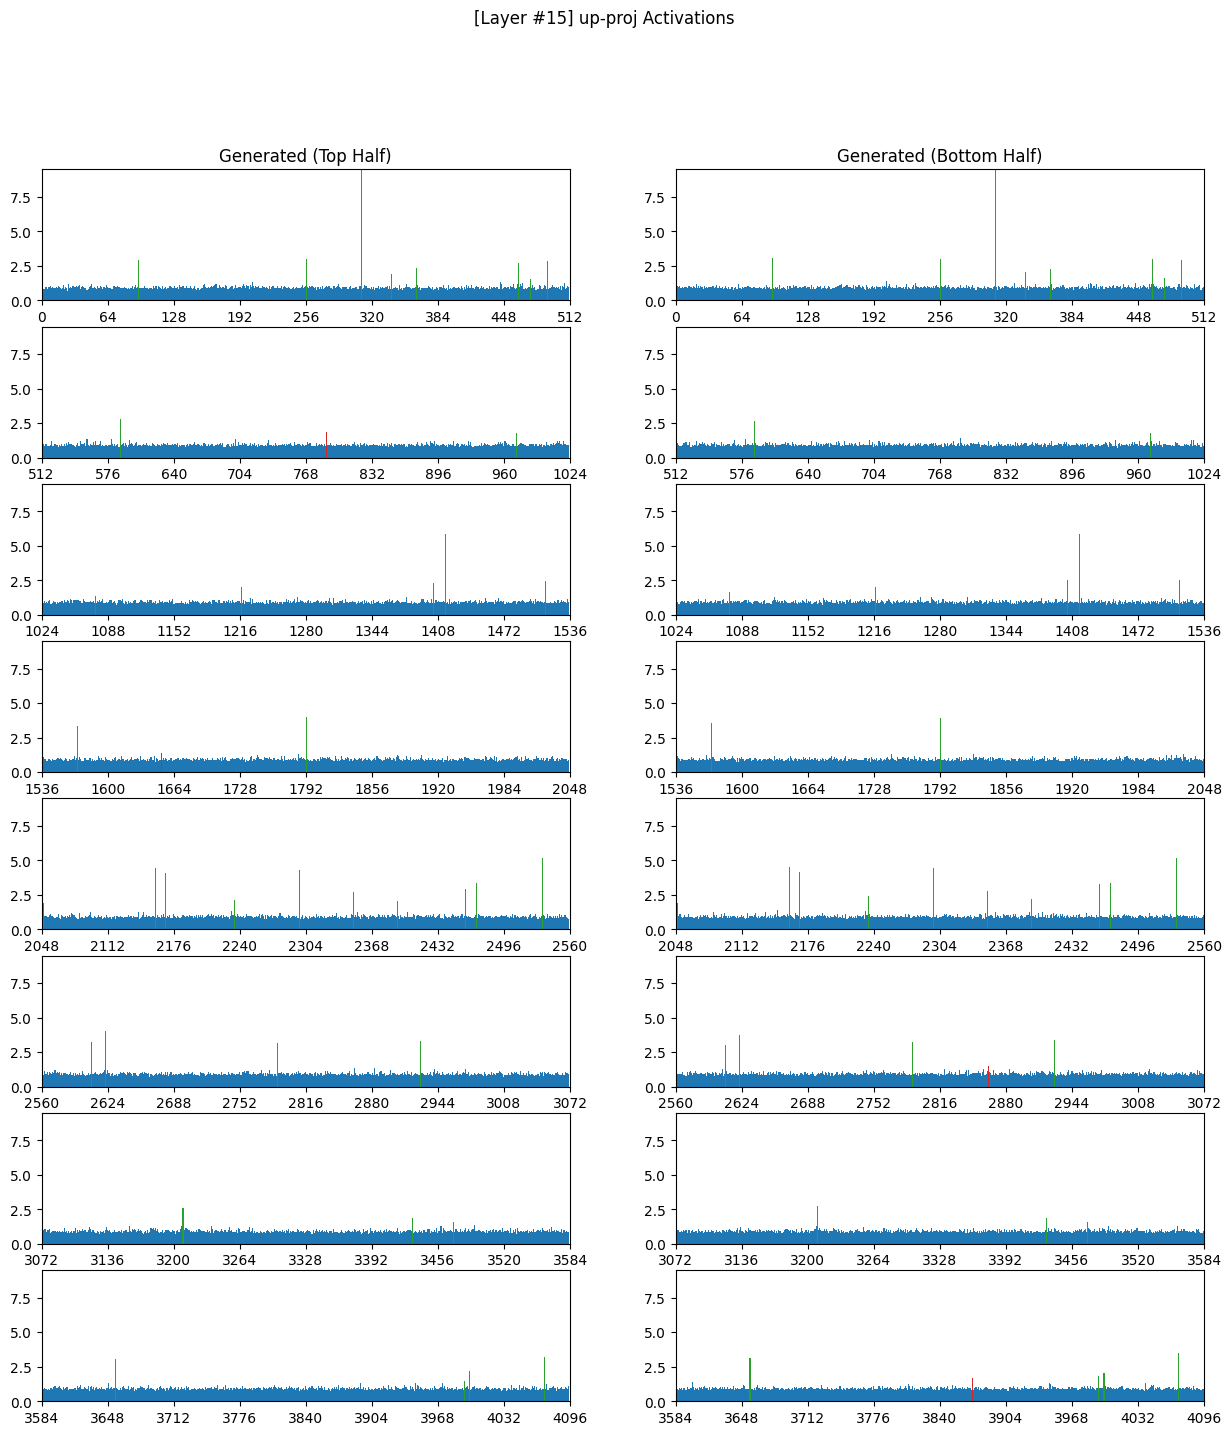

In [ ]:
layer = 15
comp = 'up-proj'
text_per_channel_1 = load_act(f'{SNAPSHOT_PATH}/activations-gen', f'{layer}-{comp}', seq_start=0, seq_end=500)
text_per_channel_2 = load_act(f'{SNAPSHOT_PATH}/activations-gen', f'{layer}-{comp}', seq_start=500, seq_end=1000)
titles = [
    f'[Layer #{layer}] {comp} Activations',
    'Generated (Top Half)',
    'Generated (Bottom Half)',
]
plot_layer_2(text_per_channel_1, text_per_channel_2, titles)

12
310 8.9
2158 4.01


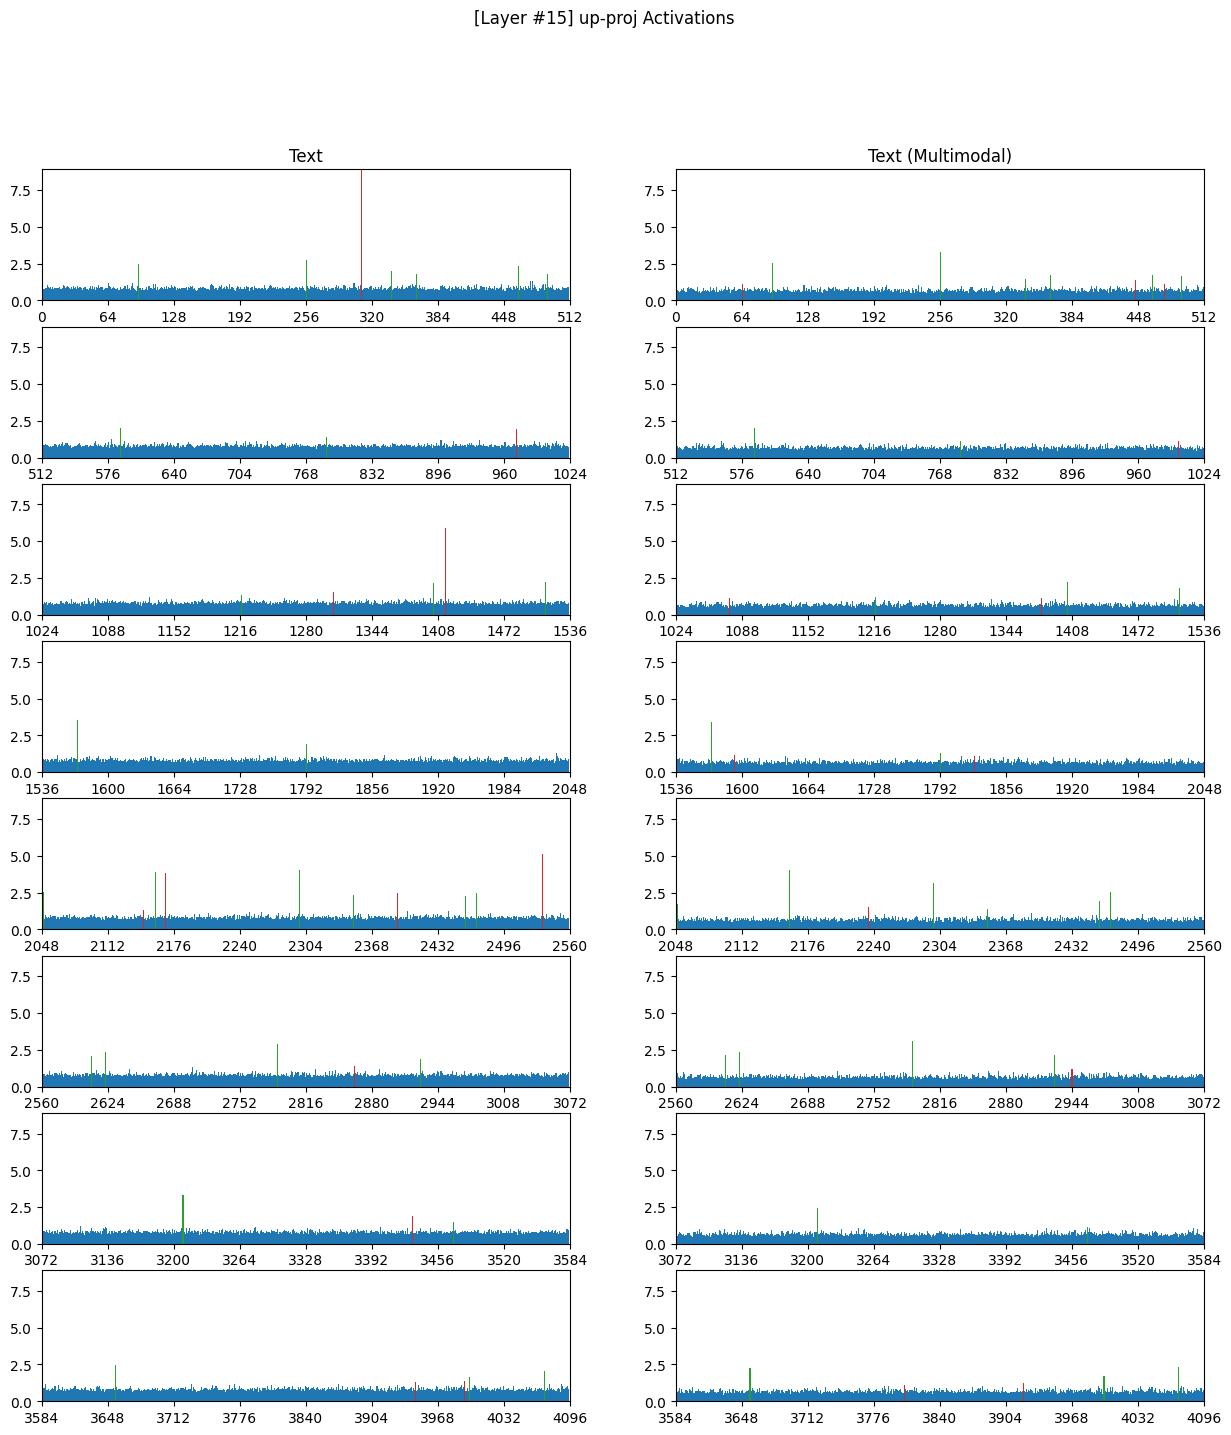

In [ ]:
layer = 15
comp = 'up-proj'
# vision_per_channel = load_act(f'{SNAPSHOT_PATH}/activations', f'{layer}-{comp}', token_end=577)
mm_text_per_channel = load_act(f'{SNAPSHOT_PATH}/activations', f'{layer}-{comp}', token_start=577)
text_per_channel = load_act(f'{SNAPSHOT_PATH}/activations-text', f'{layer}-{comp}', seq_end=100)
titles = [
    f'[Layer #{layer}] {comp} Activations',
    'Text',
    'Text (Multimodal)',
]
plot_layer_2(text_per_channel, mm_text_per_channel, titles)

In [11]:
def plot_all_comp_1(layer, channel):
    plt.figure(figsize=(10, 16))

    for i, comp in enumerate(['q-proj', 'o-proj', 'up-proj', 'down-proj']):
        title = f'[L{layer}.{comp}] Multimodal (Text)'
        ax = plt.subplot(4, 2, i * 2 + 1)
        x = load_channel(f'{SNAPSHOT_PATH}/activations', f'{layer}-{comp}', channel, token_start=577).detach().cpu().numpy()
        plot_channel(ax, x, bins=50)
        ax.set_title(title)
        print(title)
        # title = f'[L{layer}.{comp}] Multimodal (Vision)'
        title = f'[L{layer}.{comp}] Multimodal (Gen)'
        ax = plt.subplot(4, 2, i * 2 + 2)
        # x = load_channel(f'{SNAPSHOT_PATH}/activations', f'{layer}-{comp}', channel, token_start=1, token_end=577).detach().cpu().numpy()
        x = load_channel(f'{SNAPSHOT_PATH}/activations-gen-long', f'{layer}-{comp}', channel, seq_end=100).detach().cpu().numpy()
        plot_channel(ax, x)
        ax.set_title(title)
        print(title)

    plt.savefig(f'./snapshot/img/activations-per-channel/{layer}.{channel}.png')

[L3.q-proj] Multimodal (Text)
[L3.q-proj] Multimodal (Gen)
[L3.o-proj] Multimodal (Text)
[L3.o-proj] Multimodal (Gen)
[L3.up-proj] Multimodal (Text)
[L3.up-proj] Multimodal (Gen)
[L3.down-proj] Multimodal (Text)
[L3.down-proj] Multimodal (Gen)


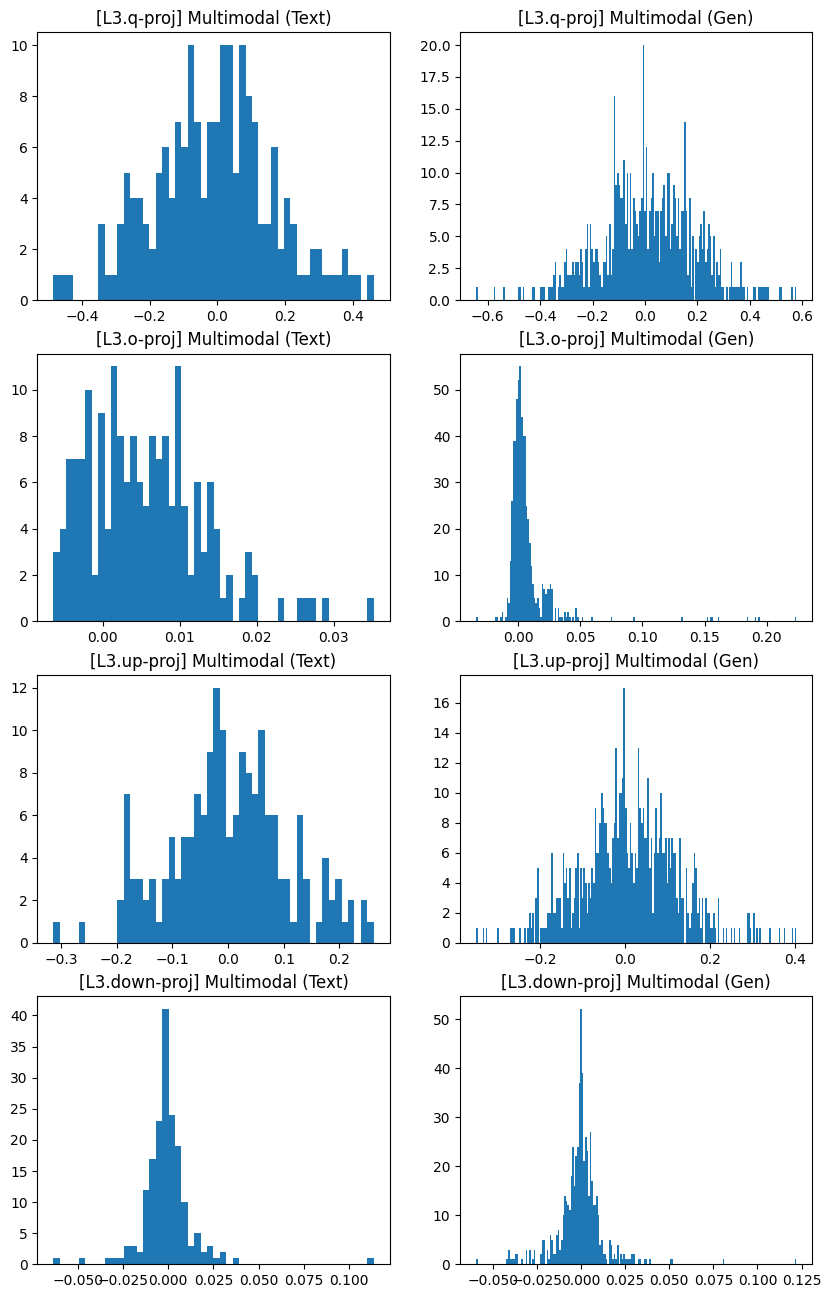

In [12]:
layer=3
plot_all_comp_1(layer, channel=31, )